In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *
from tqdm import tqdm


setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7cfb346bd640>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7cfb346bd640>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7cfb346bd640>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)


In [2]:
%%time
# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32*4, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(tqdm(test_loader_sst)):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=100)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

<timed exec>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 29/29 [01:32<00:00,  3.21s/it]


Model 1 evaluation complete!
CPU times: user 13min 44s, sys: 1min 32s, total: 15min 17s
Wall time: 1min 41s


In [4]:
# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    #('ssh_only', results_ssh_only, True, False), 
    #('mse_only', results_mse_only, False, True)
]

# Store all datasets
eval_datasets = {}

for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst, stochastic_samples=100)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset

Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 100, 1, 80, 80)


In [5]:
# Chunk for some parallelization (not needed, but makes things potentially faster)
# Add km coordinates

for k in eval_datasets.keys(): 
    eval_datasets[k] = eval_datasets[k].chunk(chunks={'sample' : 100, 'stochastic_sample':100}) 
    eval_datasets[k] = eval_datasets[k].assign_coords(i = eval_datasets[k].i *1.5, j = eval_datasets[k].j *1.5)

In [6]:
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx  = np.where(clean_mask)[0]

In [22]:
3041 in clean_idx

True

In [7]:
# Analysis by PSD Intersection Bins (Log-spaced)
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import xrft
from scipy.interpolate import interp1d
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

def isotropic_spectra(data):
    """Calculate the isotropic power spectrum of input data."""
    iso_psd = xrft.isotropic_power_spectrum(
        data, 
        dim=['i', 'j'], 
        detrend='constant', 
        window=True,
        nfactor=2
    )
    return iso_psd

def calculate_psd_km(field, dx=1.5):
    """Calculate PSD with spatial coordinates in km."""
    i_km = np.arange(field.shape[0]) * dx
    j_km = np.arange(field.shape[1]) * dx
    da = xr.DataArray(
        field,
        dims=['i', 'j'],
        coords={'i': i_km, 'j': j_km},
        name='field'
    )
    return isotropic_spectra(da)



def find_psd_intersection(bm_psd, ubm_psd, wavenumbers):
    """Find the first intersection point (smallest wavenumber) between BM and UBM PSDs"""
    try:
        # Find where UBM crosses above BM (or vice versa)
        diff = ubm_psd - bm_psd
        
        # Look for sign changes
        sign_changes = np.where(np.diff(np.sign(diff)))[0]
        
        if len(sign_changes) == 0:
            return None  # No intersection found
        
        # Return the wavenumber of the first intersection (smallest wavenumber)
        first_intersection_idx = sign_changes[0]
        
        # Linear interpolation to get more precise intersection point
        k1, k2 = wavenumbers[first_intersection_idx], wavenumbers[first_intersection_idx + 1]
        d1, d2 = diff[first_intersection_idx], diff[first_intersection_idx + 1]
        
        # Linear interpolation: find where diff crosses zero
        intersection_k = k1 - d1 * (k2 - k1) / (d2 - d1)
        
        return intersection_k
        
    except Exception as e:
        return None

def create_log_bins(k_min=1/120, k_max=1/2, n_bins=3):
    """Create equally spaced log bins across the wavenumber range"""
    log_min = np.log10(k_min)
    log_max = np.log10(k_max)
    
    # Create bin edges in log space
    log_edges = np.linspace(log_min, log_max, n_bins + 1)
    bin_edges = 10**log_edges
    
    return bin_edges

def custom_bins(): 
    return np.array([1/120, 1/40, 1/10, 1/1])

def bin_samples_by_intersection_logspace(eval_dataset, test_data, clean_idx_subset):
    """Bin samples based on BM-UBM PSD intersection wavenumbers using log-spaced bins"""
    
    # Create 4 equally spaced log bins
    #bin_edges = create_log_bins()
    bin_edges = custom_bins()
    n_bins = len(bin_edges) - 1
    
    # Initialize bins
    bins = {f'bin_{i}': [] for i in range(n_bins)}
    no_intersection_samples = []
    intersection_wavenumbers = []

    print("Bin edges (spatial scale in km):")
    for i in range(n_bins):
        km_low = 1/bin_edges[i+1]  # Note: reversed order since 1/k
        km_high = 1/bin_edges[i]
        print(f"Bin {i+1}: [{km_low:.1f}, {km_high:.1f}) km")
    
    # print("Bin edges (wavenumber):")
    # for i in range(n_bins):
    #     print(f"Bin {i+1}: [{bin_edges[i]:.4f}, {bin_edges[i+1]:.4f})")
    
    for sample_idx in tqdm(clean_idx_subset): #!! these kind of for loops are very slow.
        try:
            # Get true BM and UBM for this sample
            bm_true = eval_dataset.bm_truth.isel(sample=sample_idx).values
            ubm_true = eval_dataset.ubm_truth.isel(sample=sample_idx).values
            
            # Skip samples with NaNs
            if np.any(np.isnan(bm_true)) or np.any(np.isnan(ubm_true)):
                continue
                
            # Calculate PSDs
            psd_bm = calculate_psd_km(bm_true)
            #psd_bm = isotropic_spectra(bm_true)
            psd_ubm = calculate_psd_km(ubm_true)
            #psd_ubm = isotropic_spectra(ubm_true)
            
            wavenumbers = psd_bm[list(psd_bm.coords.keys())[0]].values
            
            # Find intersection
            intersection_k = find_psd_intersection(psd_bm.values, psd_ubm.values, wavenumbers)
            
            # Bin the sample
            if intersection_k is None:
                no_intersection_samples.append(sample_idx)
            else:
                intersection_wavenumbers.append(intersection_k)
                
                # Find which bin this intersection falls into
                bin_idx = np.digitize(intersection_k, bin_edges) - 1
                
                # Make sure it's within valid range
                if 0 <= bin_idx < n_bins:
                    bins[f'bin_{bin_idx}'].append(sample_idx)
                else:
                    no_intersection_samples.append(sample_idx)
                
        except Exception as e:
            continue
    
    return bins, no_intersection_samples, intersection_wavenumbers, bin_edges


In [8]:
# Bin samples by intersection wavenumbers
bins, no_intersection, intersection_ks, bin_edges = bin_samples_by_intersection_logspace(
    eval_datasets['sst_ssh'], test, clean_idx)

Bin edges (spatial scale in km):
Bin 1: [40.0, 120.0) km
Bin 2: [10.0, 40.0) km
Bin 3: [1.0, 10.0) km


100%|██████████| 2907/2907 [01:22<00:00, 35.24it/s]


In [11]:
import matplotlib.pyplot as plt
model_name = 'sst_ssh'
ds = eval_datasets[model_name].sel(sample=clean_idx)

In [73]:
ds

<xarray.Dataset> Size: 15GB
Dimensions:            (sample: 2907, i: 80, j: 80, stochastic_sample: 100)
Coordinates:
  * sample             (sample) int64 23kB 28 29 30 31 ... 3608 3609 3610 3611
  * stochastic_sample  (stochastic_sample) int64 800B 0 1 2 3 4 ... 96 97 98 99
  * i                  (i) float64 640B 0.0 1.5 3.0 4.5 ... 115.5 117.0 118.5
  * j                  (j) float64 640B 0.0 1.5 3.0 4.5 ... 115.5 117.0 118.5
Data variables:
    ssh                (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    ubm_truth          (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    bm_truth           (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    ubm_pred_mean      (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    bm_pred_mean       (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    sst                (sample, i, j) float32 74MB dask.array<chunksize=(98, 80, 80), meta=np.ndarray>
    ubm_pred_samples   (sample, stochastic_sample, i, j) float32 7GB dask.array<chunksize=(98, 100, 80, 80), meta=np.ndarray>
    bm_pred_samples    (sample, stochastic_sample, i, j) float32 7GB dask.array<chunksize=(98, 100, 80, 80), meta=np.ndarray>

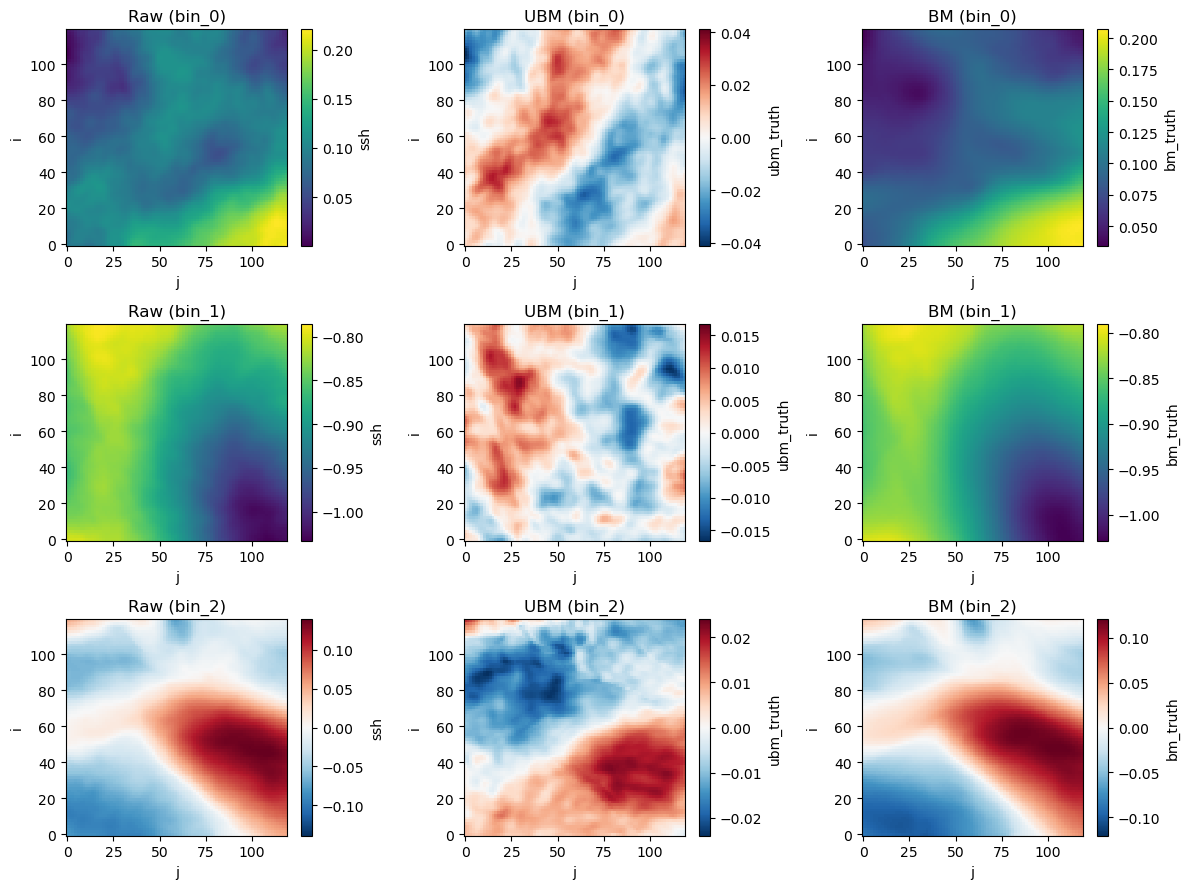

In [75]:
# Configuration for each row
plot_configs = [
    ('bin_0', -0.04),
    ('bin_1', -0.04), 
    ('bin_2', -0.04)
]

# Plot specifications: (title, data_accessor)
plot_specs = [
    ('Raw', lambda nsamp: ds.ssh.sel(sample=nsamp)),
    ('UBM', lambda nsamp: ds.ubm_truth.sel(sample=nsamp)),
    ('BM', lambda nsamp: ds.bm_truth.sel(sample=nsamp)),
    
]

# Create the combined plot
plt.figure(figsize=(12, 9))

for row, (bin_name, vmin) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(3, 3, row * 3 + col + 1)
        data_func(nsamp).plot()#vmin=vmin)
        plt.title(f'{title} ({bin_name})')

plt.tight_layout()
plt.show()

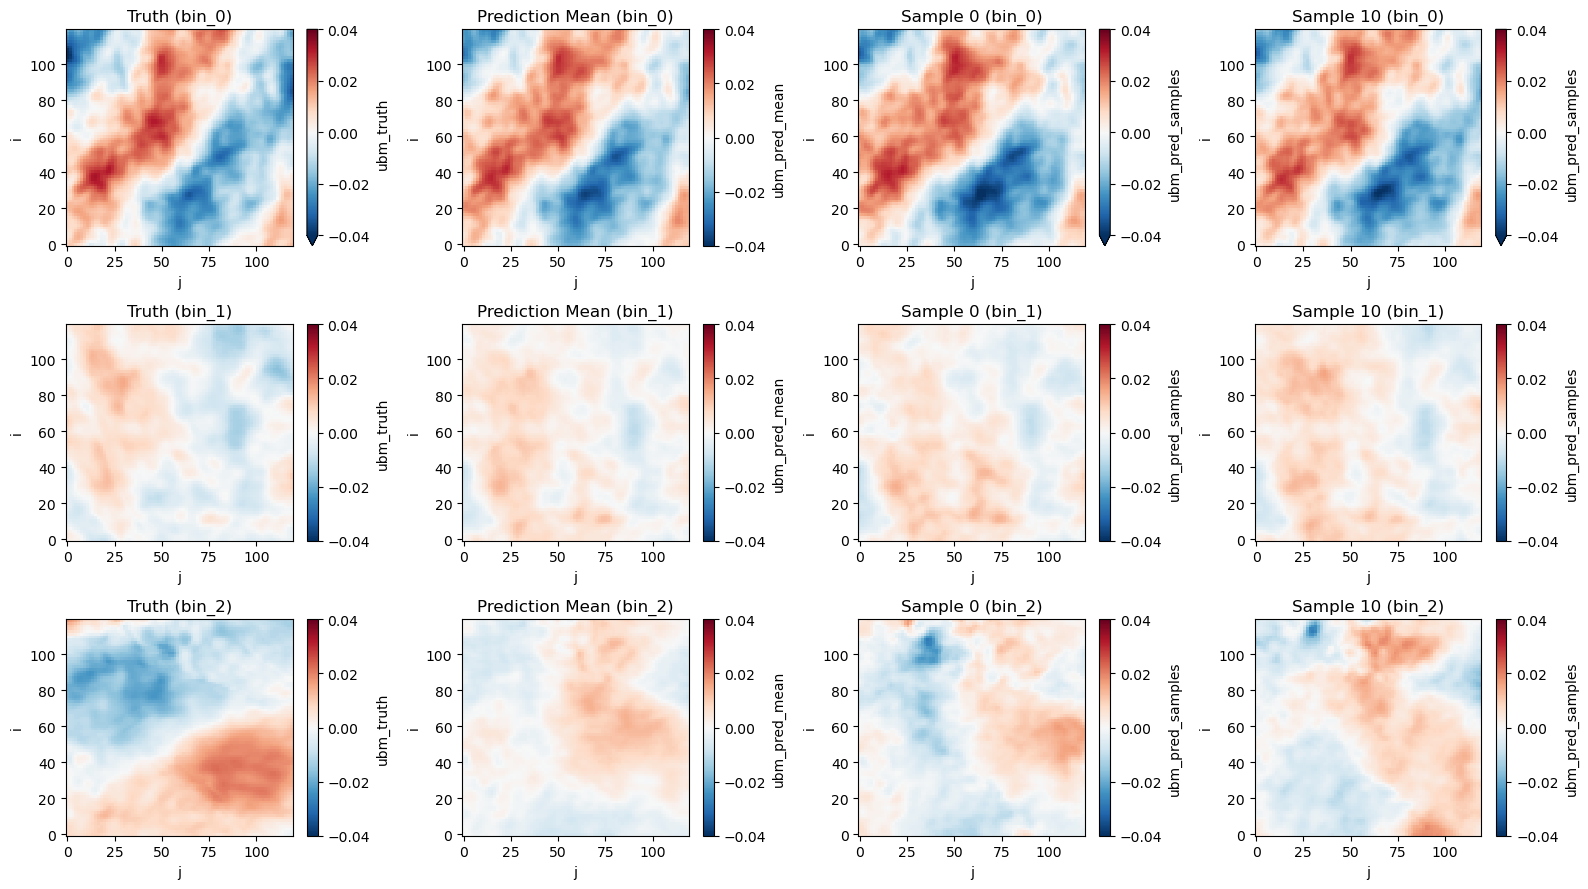

In [54]:
# Configuration for each row
plot_configs = [
    ('bin_0', -0.04),
    ('bin_1', -0.04), 
    ('bin_2', -0.04)
]

# Plot specifications: (title, data_accessor)
plot_specs = [
    ('Truth', lambda nsamp: ds.ubm_truth.sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp: ds.ubm_pred_mean.sel(sample=nsamp)),
    ('Sample 0', lambda nsamp: ds.ubm_pred_samples.sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp: ds.ubm_pred_samples.sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot
plt.figure(figsize=(16, 9))

for row, (bin_name, vmin) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(3, 4, row * 4 + col + 1)
        data_func(nsamp).plot(vmin=vmin)
        plt.title(f'{title} ({bin_name})')

plt.tight_layout()
plt.show()

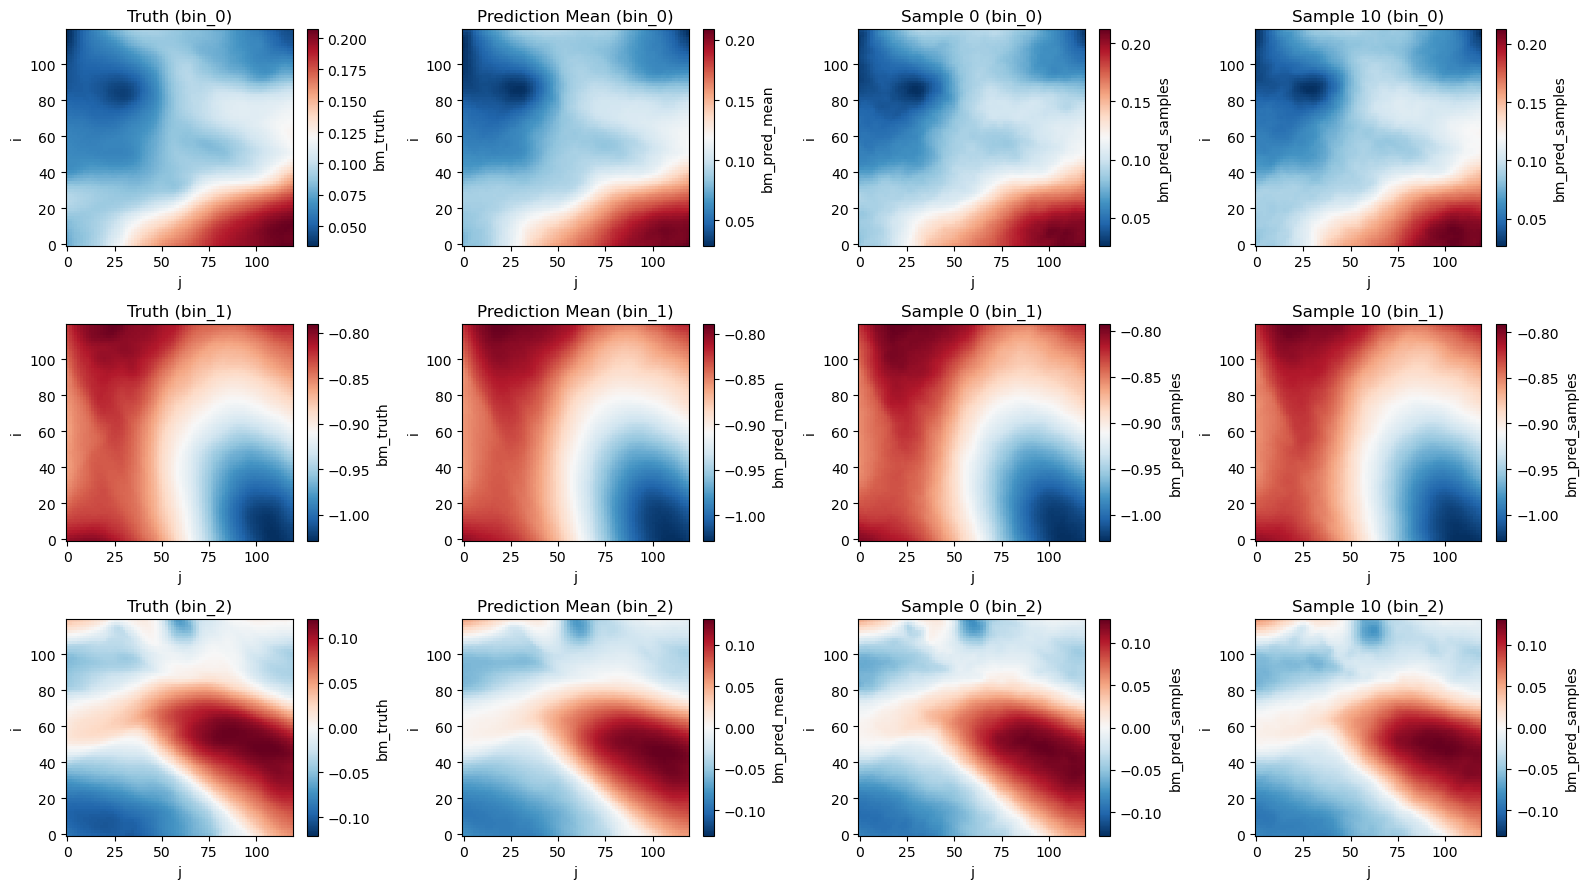

In [55]:
# Configuration for each row
plot_configs = [
    ('bin_0', -0.2),
    ('bin_1', -0.2), 
    ('bin_2', -0.2)
]

# Plot specifications: (title, data_accessor)
plot_specs = [
    ('Truth', lambda nsamp: ds.bm_truth.sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp: ds.bm_pred_mean.sel(sample=nsamp)),
    ('Sample 0', lambda nsamp: ds.bm_pred_samples.sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp: ds.bm_pred_samples.sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot
plt.figure(figsize=(16, 9))

for row, (bin_name, vmin) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(3, 4, row * 4 + col + 1)
        data_func(nsamp).plot(cmap='RdBu_r')#vmin=vmin, vmax=-vmin)
        plt.title(f'{title} ({bin_name})')

plt.tight_layout()
plt.show()

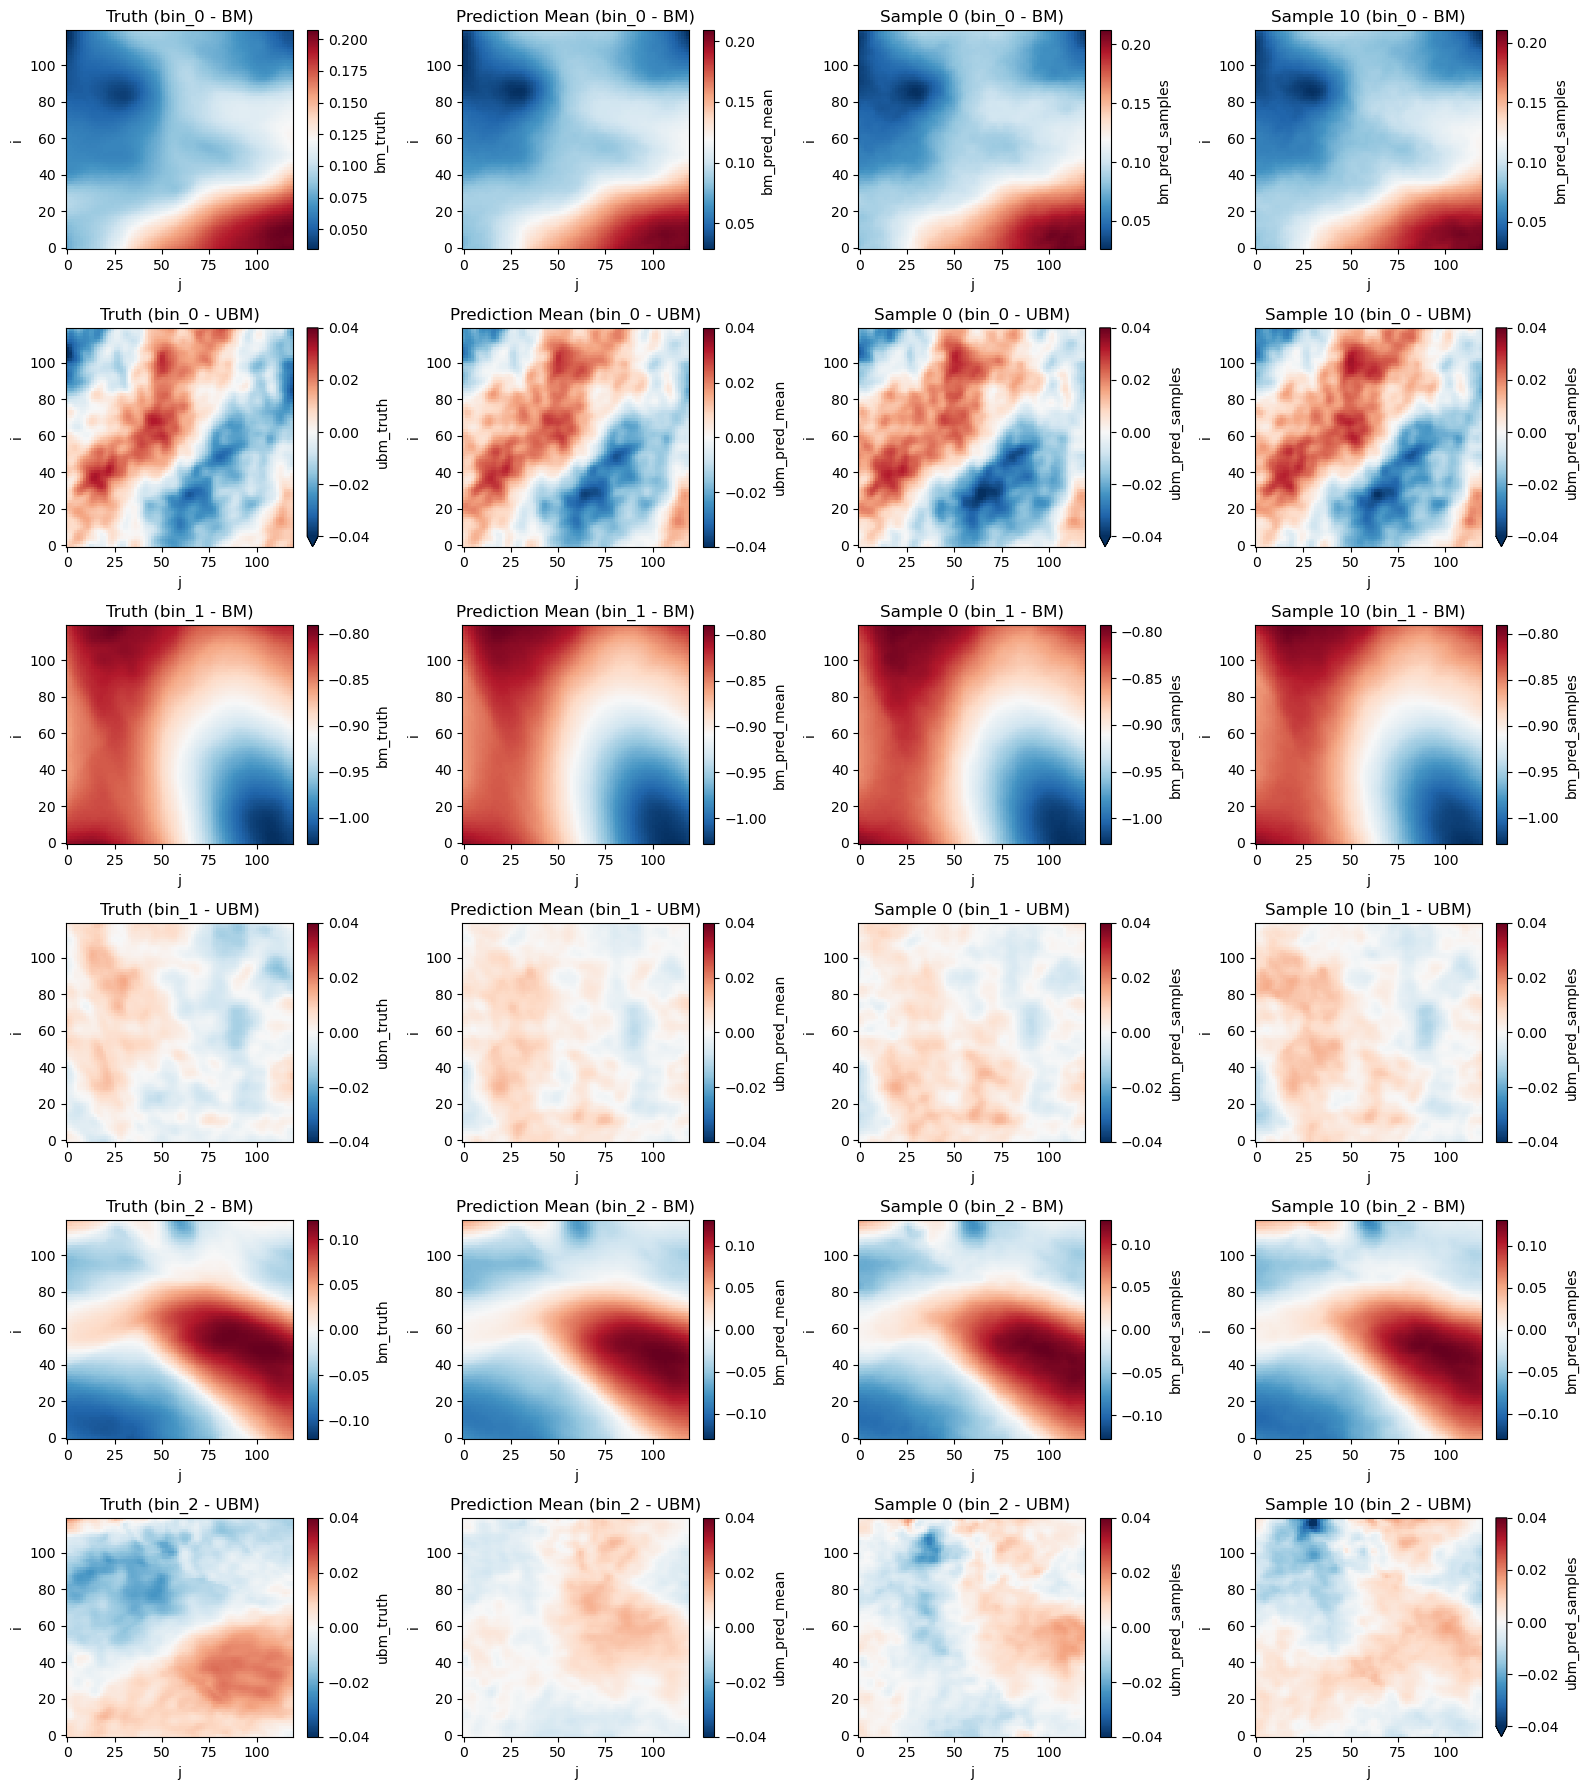

In [57]:
# Configuration for each bin with both BM and UBM settings
plot_configs = [
    ('bin_0', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_0', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_1', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_1', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_2', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_2', 'UBM', -0.04, 'ubm', {'vmin': -0.04})
]

# Plot specifications: (title, data_accessor_template)
plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 0', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=50))
]

# Create the combined plot
plt.figure(figsize=(16, 18))

for row, (bin_name, model_type, vmin, data_type, plot_kwargs) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(6, 4, row * 4 + col + 1)
        data_func(nsamp, data_type).plot(**plot_kwargs)
        plt.title(f'{title} ({bin_name} - {model_type})')

plt.tight_layout()
plt.show()

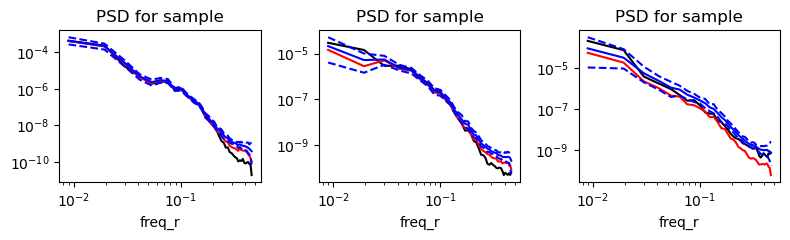

In [59]:
#nsamp = 2000
plt.figure(figsize=(8, 2.5))

for i, k in enumerate(bins.keys()):
    nsamp = bins[k][5]

    
    psd_true = isotropic_spectra(ds.ubm_truth.sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(ds.ubm_pred_mean.sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(ds.ubm_pred_samples.sel(sample=nsamp))

    plt.subplot(1,3,i+1)
    psd_true.plot(color='k')
    psd_pred_mean.plot(color='r')
    #psd_pred_samp.isel(stochastic_sample=0).plot(linewidth=0.6)
    #psd_pred_samp.isel(stochastic_sample=1).plot(linewidth=0.6)
    psd_pred_samp.mean('stochastic_sample').plot(color='b')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', linestyle='dashed')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', linestyle='dashed')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('PSD for sample')

plt.tight_layout()

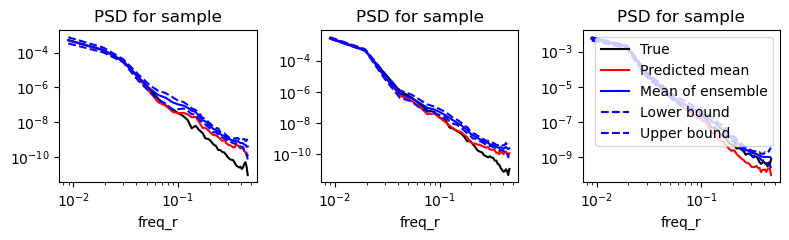

In [62]:
#nsamp = 2000
plt.figure(figsize=(8, 2.5))

for i, k in enumerate(bins.keys()):
    nsamp = bins[k][5]

    
    psd_true = isotropic_spectra(ds.bm_truth.sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(ds.bm_pred_mean.sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(ds.bm_pred_samples.sel(sample=nsamp))

    plt.subplot(1,3,i+1)
    psd_true.plot(label='True', color='k')
    psd_pred_mean.plot(label='Predicted mean', color='r')
    #psd_pred_samp.isel(stochastic_sample=0).plot(linewidth=0.6)
    #psd_pred_samp.isel(stochastic_sample=1).plot(linewidth=0.6)
    psd_pred_samp.mean('stochastic_sample').plot(label='Mean of ensemble', color='b')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', label='Lower bound', linestyle='dashed')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', label='Upper bound', linestyle='dashed')
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.title('PSD for sample')

plt.legend()
plt.tight_layout()

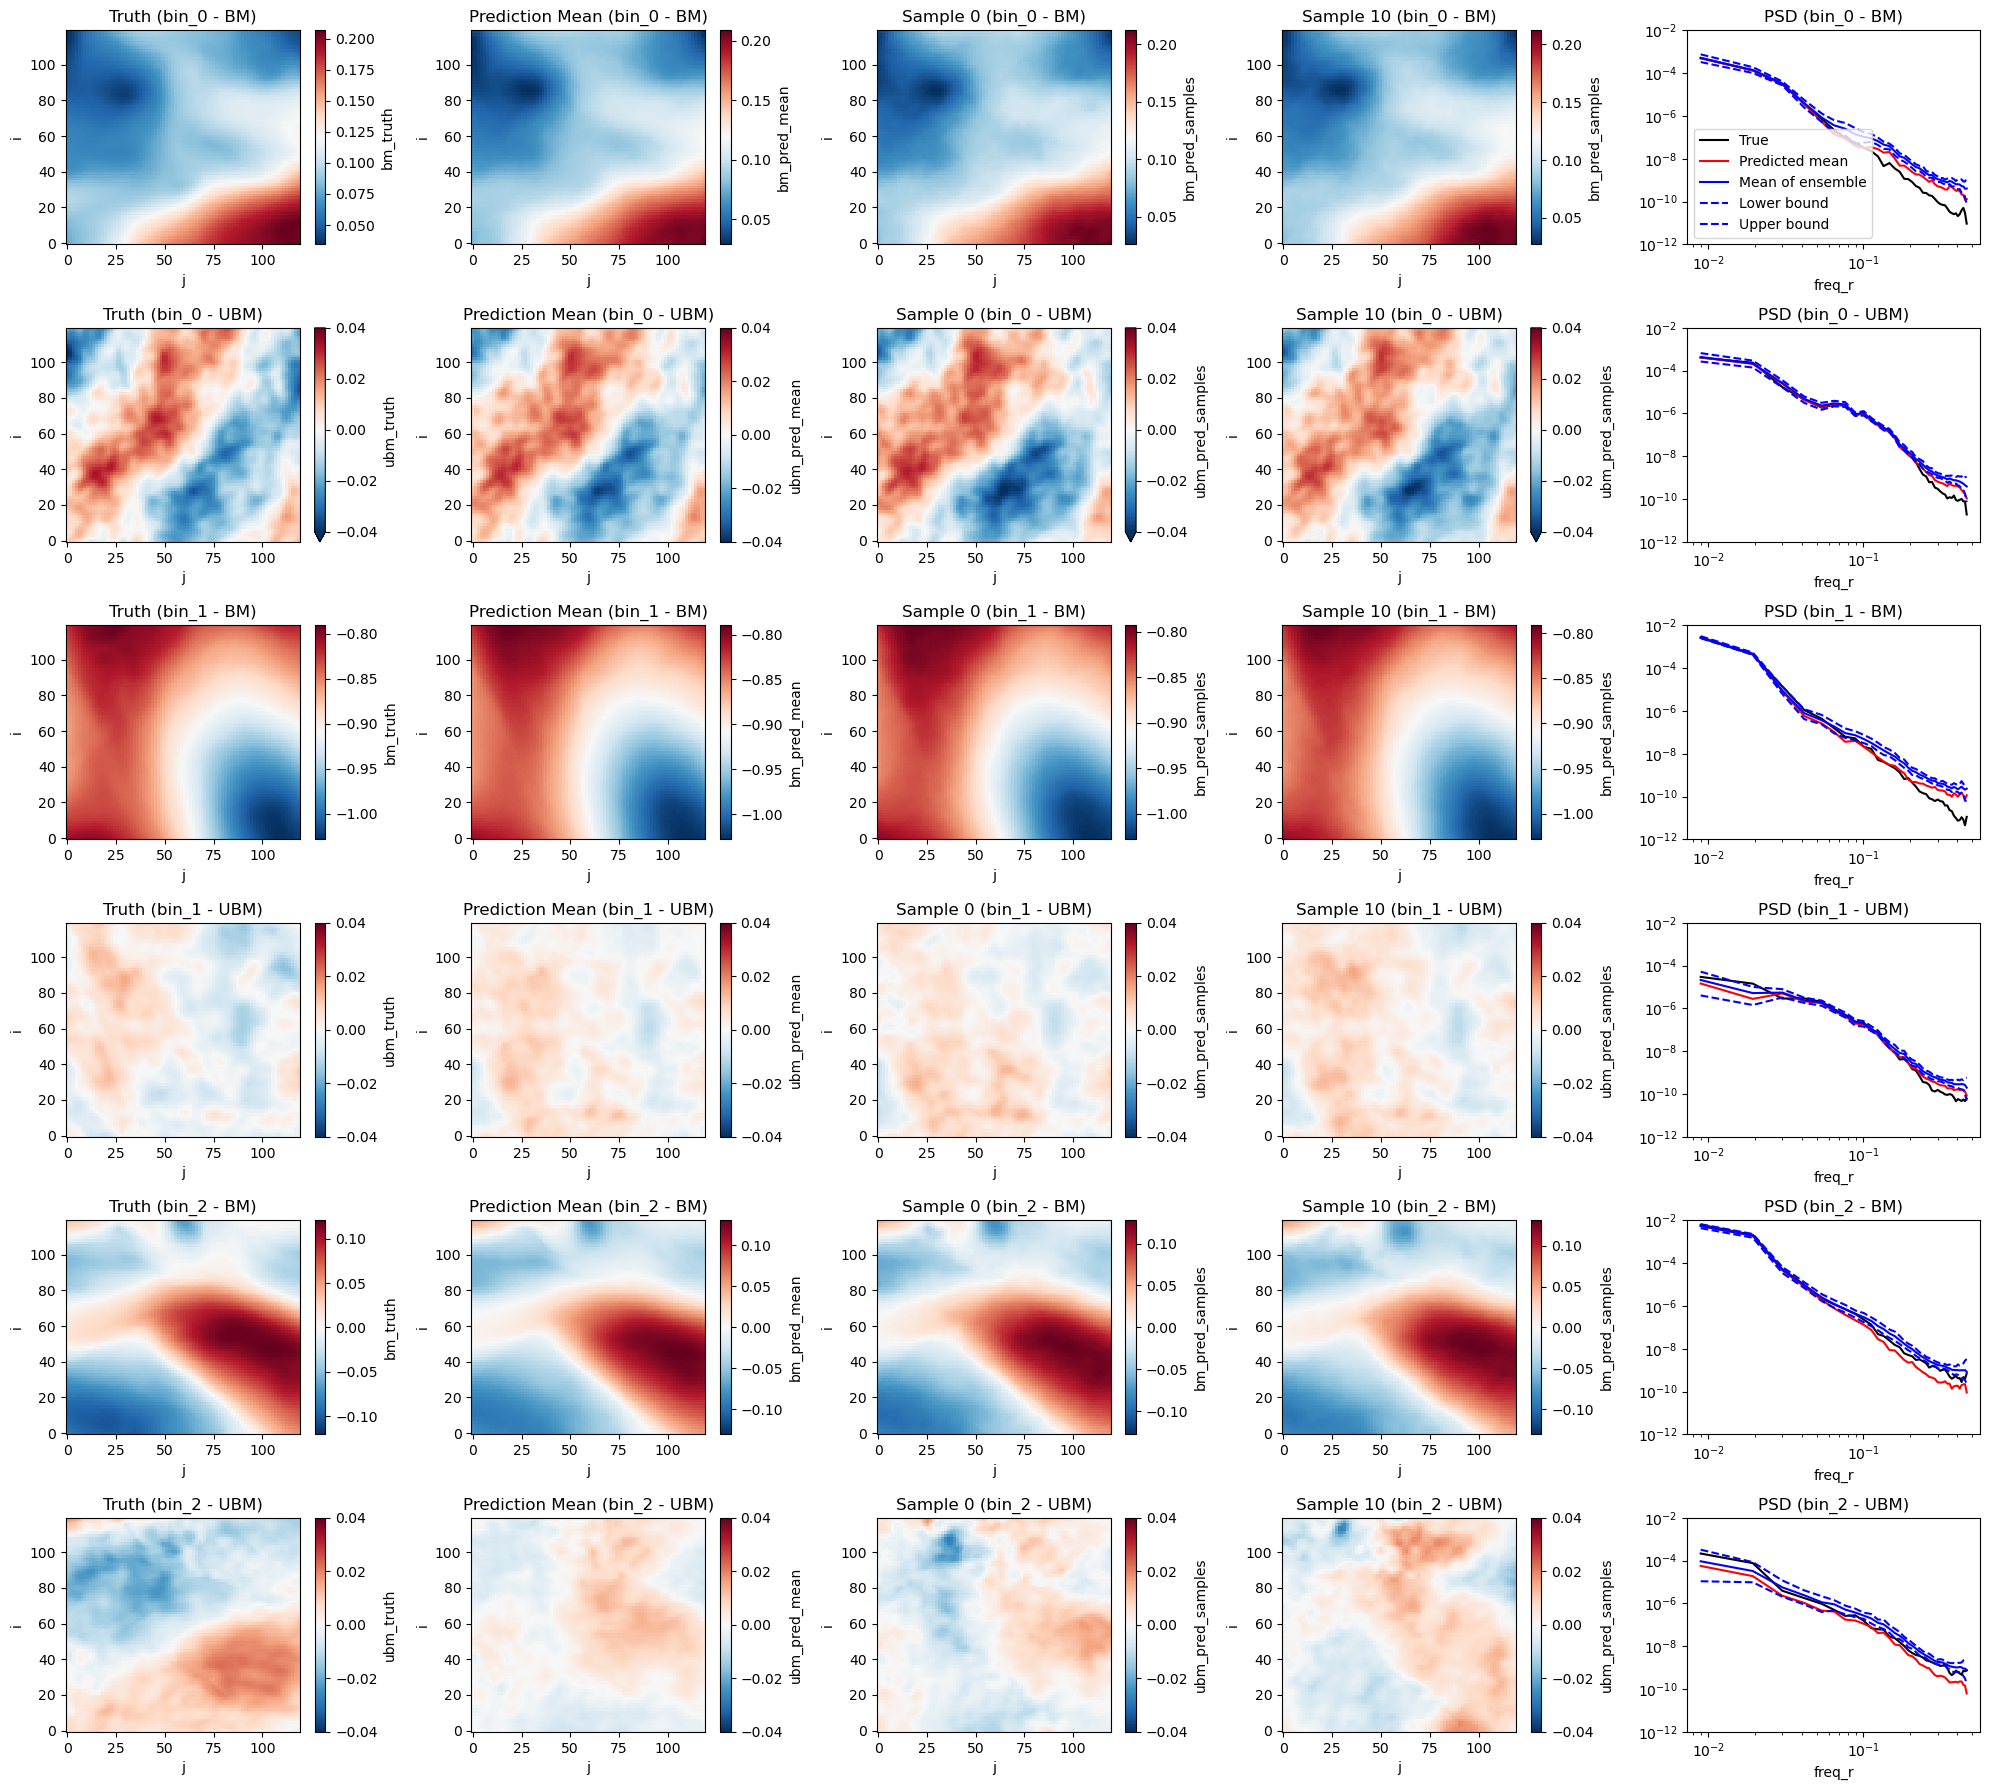

In [76]:
# Configuration for each bin with both BM and UBM settings
plot_configs = [
    ('bin_0', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_0', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_1', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_1', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_2', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_2', 'UBM', -0.04, 'ubm', {'vmin': -0.04})
]

# Plot specifications: (title, data_accessor_template)
plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 0', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot (now 6x5 to include PSD column)
plt.figure(figsize=(20, 18))

for row, (bin_name, model_type, vmin, data_type, plot_kwargs) in enumerate(plot_configs):
    nsamp = bins[bin_name][5]
    
    # Plot the 4 regular panels
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(6, 5, row * 5 + col + 1)
        data_func(nsamp, data_type).plot(**plot_kwargs)
        plt.title(f'{title} ({bin_name} - {model_type})')
    
    # Add PSD panel as 5th column
    plt.subplot(6, 5, row * 5 + 5)
    
    # Calculate PSDs
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Plot PSDs
    psd_true.plot(color='k', label='True')
    psd_pred_mean.plot(color='r', label='Predicted mean')
    psd_pred_samp.mean('stochastic_sample').plot(color='b', label='Mean of ensemble')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Lower bound')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Upper bound')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1e-12, 1e-2])
    plt.title(f'PSD ({bin_name} - {model_type})')
    
    # Add legend only for the first row to avoid clutter
    if row == 0:
        plt.legend()

plt.tight_layout()
plt.show()

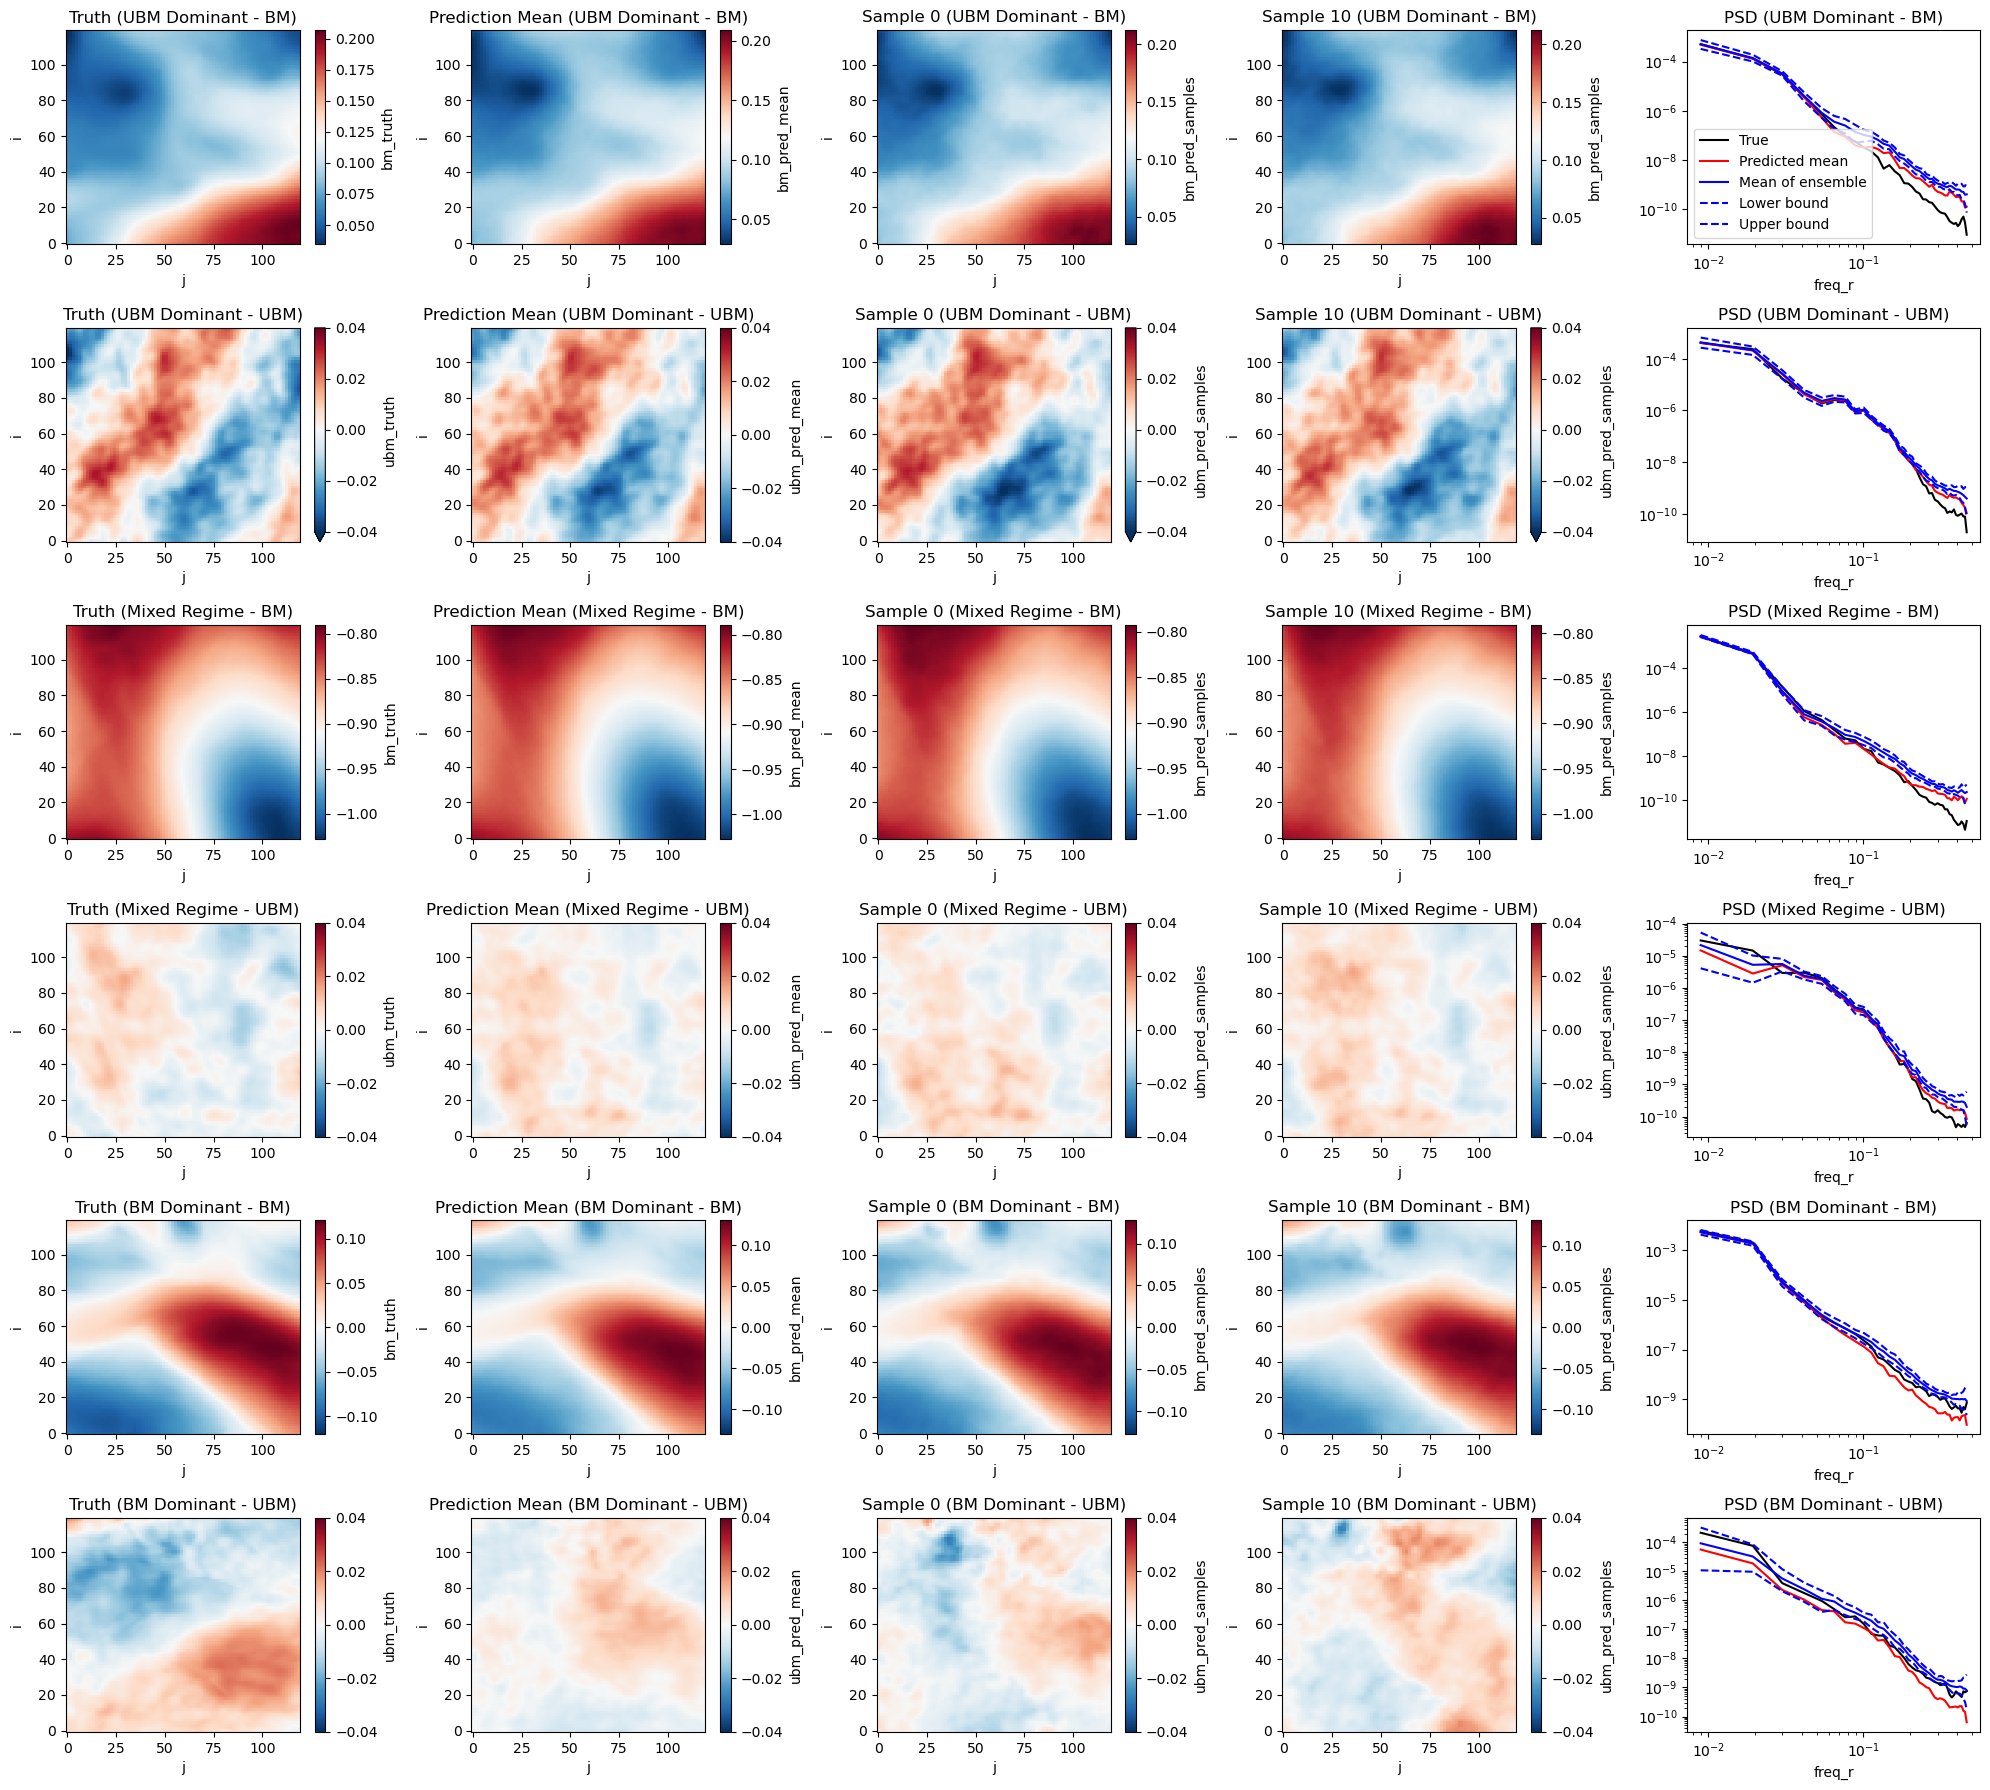

In [64]:
# Configuration for each bin with both BM and UBM settings
# (bin_key, display_name, model_type, vmin, data_type, plot_kwargs)
plot_configs = [
    ('bin_0', 'UBM Dominant', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_0', 'UBM Dominant', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_1', 'Mixed Regime', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_1', 'Mixed Regime', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_2', 'BM Dominant', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_2', 'BM Dominant', 'UBM', -0.04, 'ubm', {'vmin': -0.04})
]

# Plot specifications: (title, data_accessor_template)
plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 0', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot (now 6x5 to include PSD column)
plt.figure(figsize=(20, 18))

for row, (bin_key, display_name, model_type, vmin, data_type, plot_kwargs) in enumerate(plot_configs):
    nsamp = bins[bin_key][5]
    
    # Plot the 4 regular panels
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(6, 5, row * 5 + col + 1)
        data_func(nsamp, data_type).plot(**plot_kwargs)
        plt.title(f'{title} ({display_name} - {model_type})')
    
    # Add PSD panel as 5th column
    plt.subplot(6, 5, row * 5 + 5)
    
    # Calculate PSDs
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Plot PSDs
    psd_true.plot(color='k', label='True')
    psd_pred_mean.plot(color='r', label='Predicted mean')
    psd_pred_samp.mean('stochastic_sample').plot(color='b', label='Mean of ensemble')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Lower bound')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Upper bound')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1e-12, 1e-2])
    plt.title(f'PSD ({display_name} - {model_type})')
    
    # Add legend only for the first row to avoid clutter
    if row == 0:
        plt.legend()

plt.tight_layout()
plt.show()

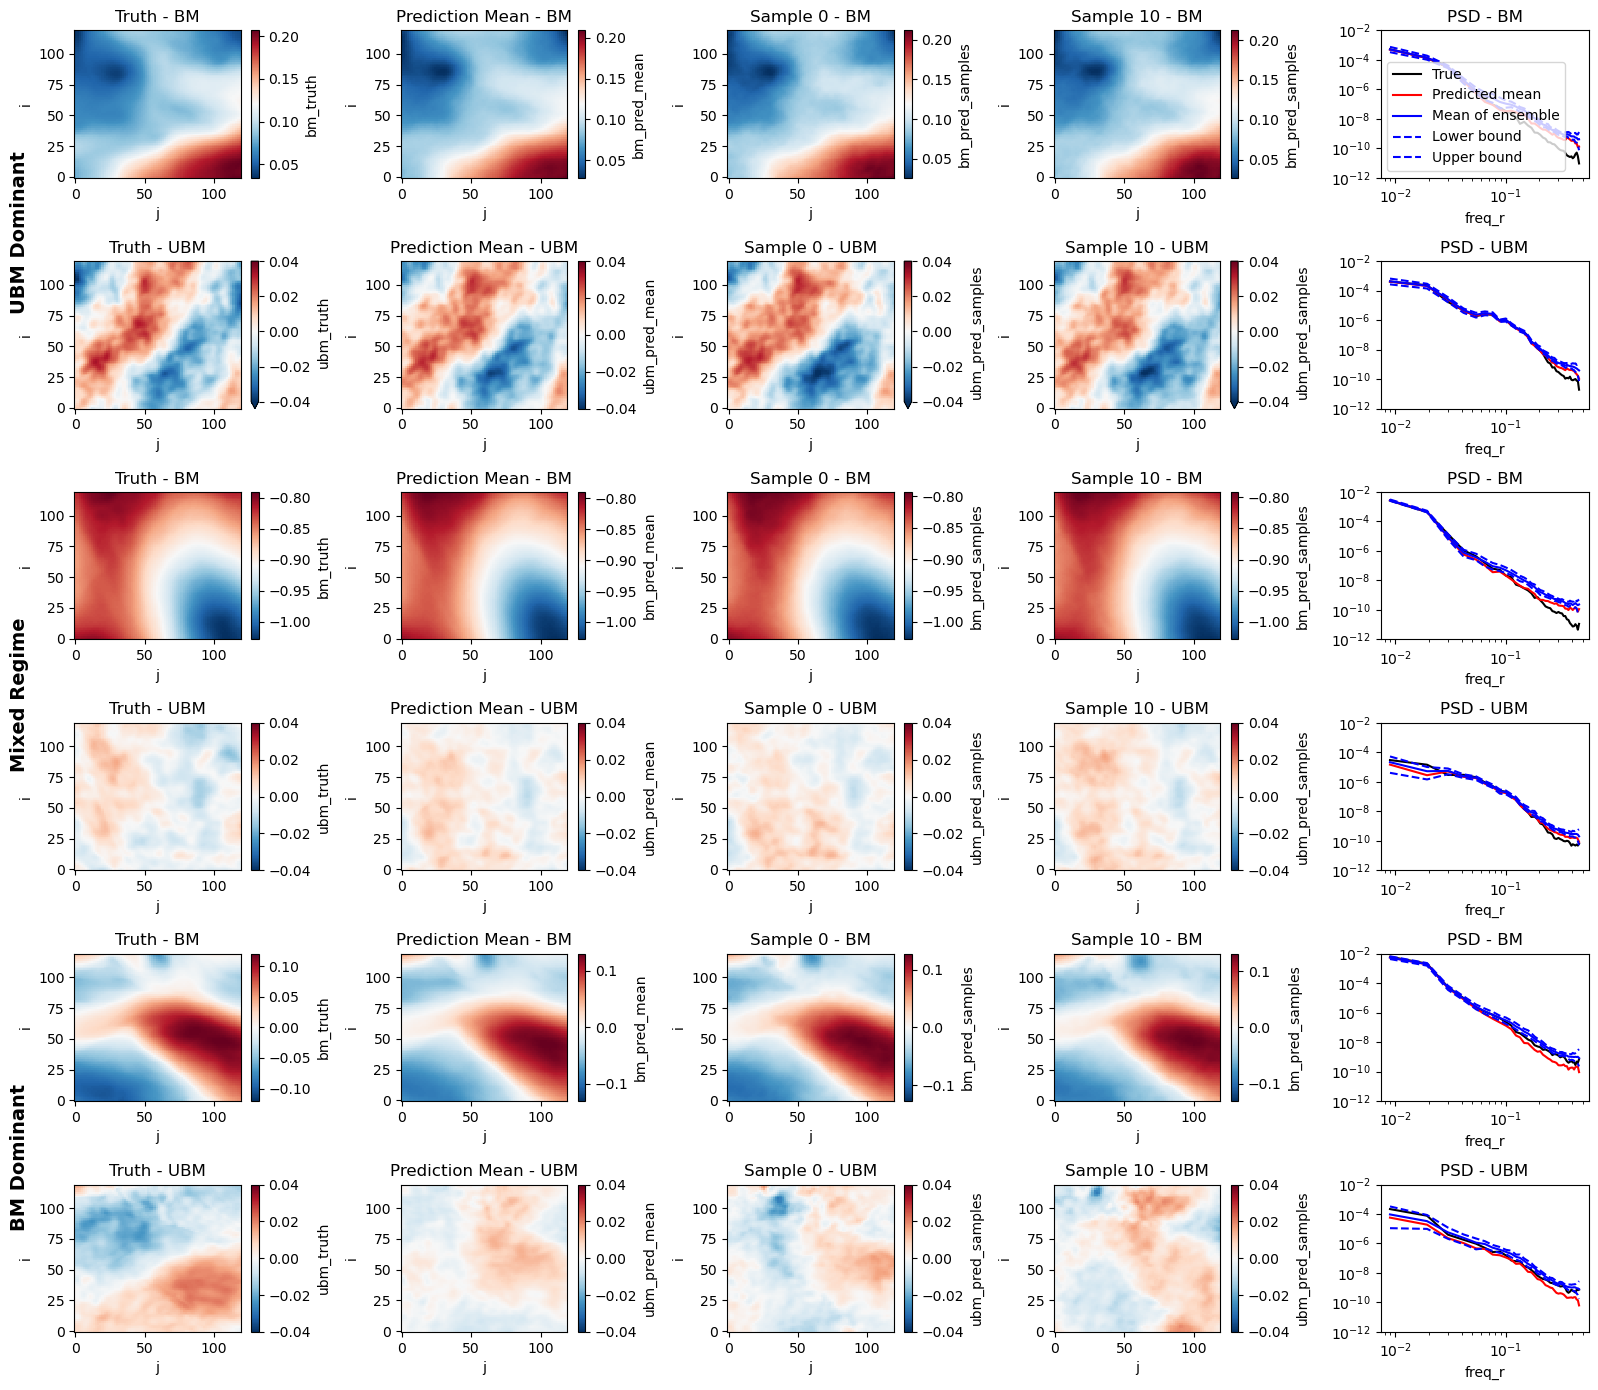

In [77]:
# Configuration for each bin with both BM and UBM settings
plot_configs = [
    ('bin_0', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_0', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_1', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_1', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_2', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_2', 'UBM', -0.04, 'ubm', {'vmin': -0.04})
]

# Regime names for left-side labels
regime_names = ['UBM Dominant', 'Mixed Regime', 'BM Dominant']

# Plot specifications: (title, data_accessor_template)
plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 0', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot (now 6x5 to include PSD column)
plt.figure(figsize=(16, 14))

for row, (bin_key, model_type, vmin, data_type, plot_kwargs) in enumerate(plot_configs):
    nsamp = bins[bin_key][5]
    
    # Plot the 4 regular panels
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(6, 5, row * 5 + col + 1)
        data_func(nsamp, data_type).plot(**plot_kwargs)
        plt.title(f'{title} - {model_type}')
    
    # Add PSD panel as 5th column
    plt.subplot(6, 5, row * 5 + 5)
    
    # Calculate PSDs
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Plot PSDs
    psd_true.plot(color='k', label='True')
    psd_pred_mean.plot(color='r', label='Predicted mean')
    psd_pred_samp.mean('stochastic_sample').plot(color='b', label='Mean of ensemble')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Lower bound')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Upper bound')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1e-12, 1e-2])
    plt.title(f'PSD - {model_type}')
    
    # Add legend only for the first row to avoid clutter
    if row == 0:
        plt.legend()

# Add regime labels on the left side
for i, regime_name in enumerate(regime_names):
    # Position text at the middle of each pair of rows
    y_pos = 0.83 - (i * 0.33)  # Roughly centered between each pair of rows
    plt.figtext(0.01, y_pos, regime_name, rotation=90, fontsize=14, 
                weight='bold', ha='center', va='center')

plt.tight_layout()
plt.show()

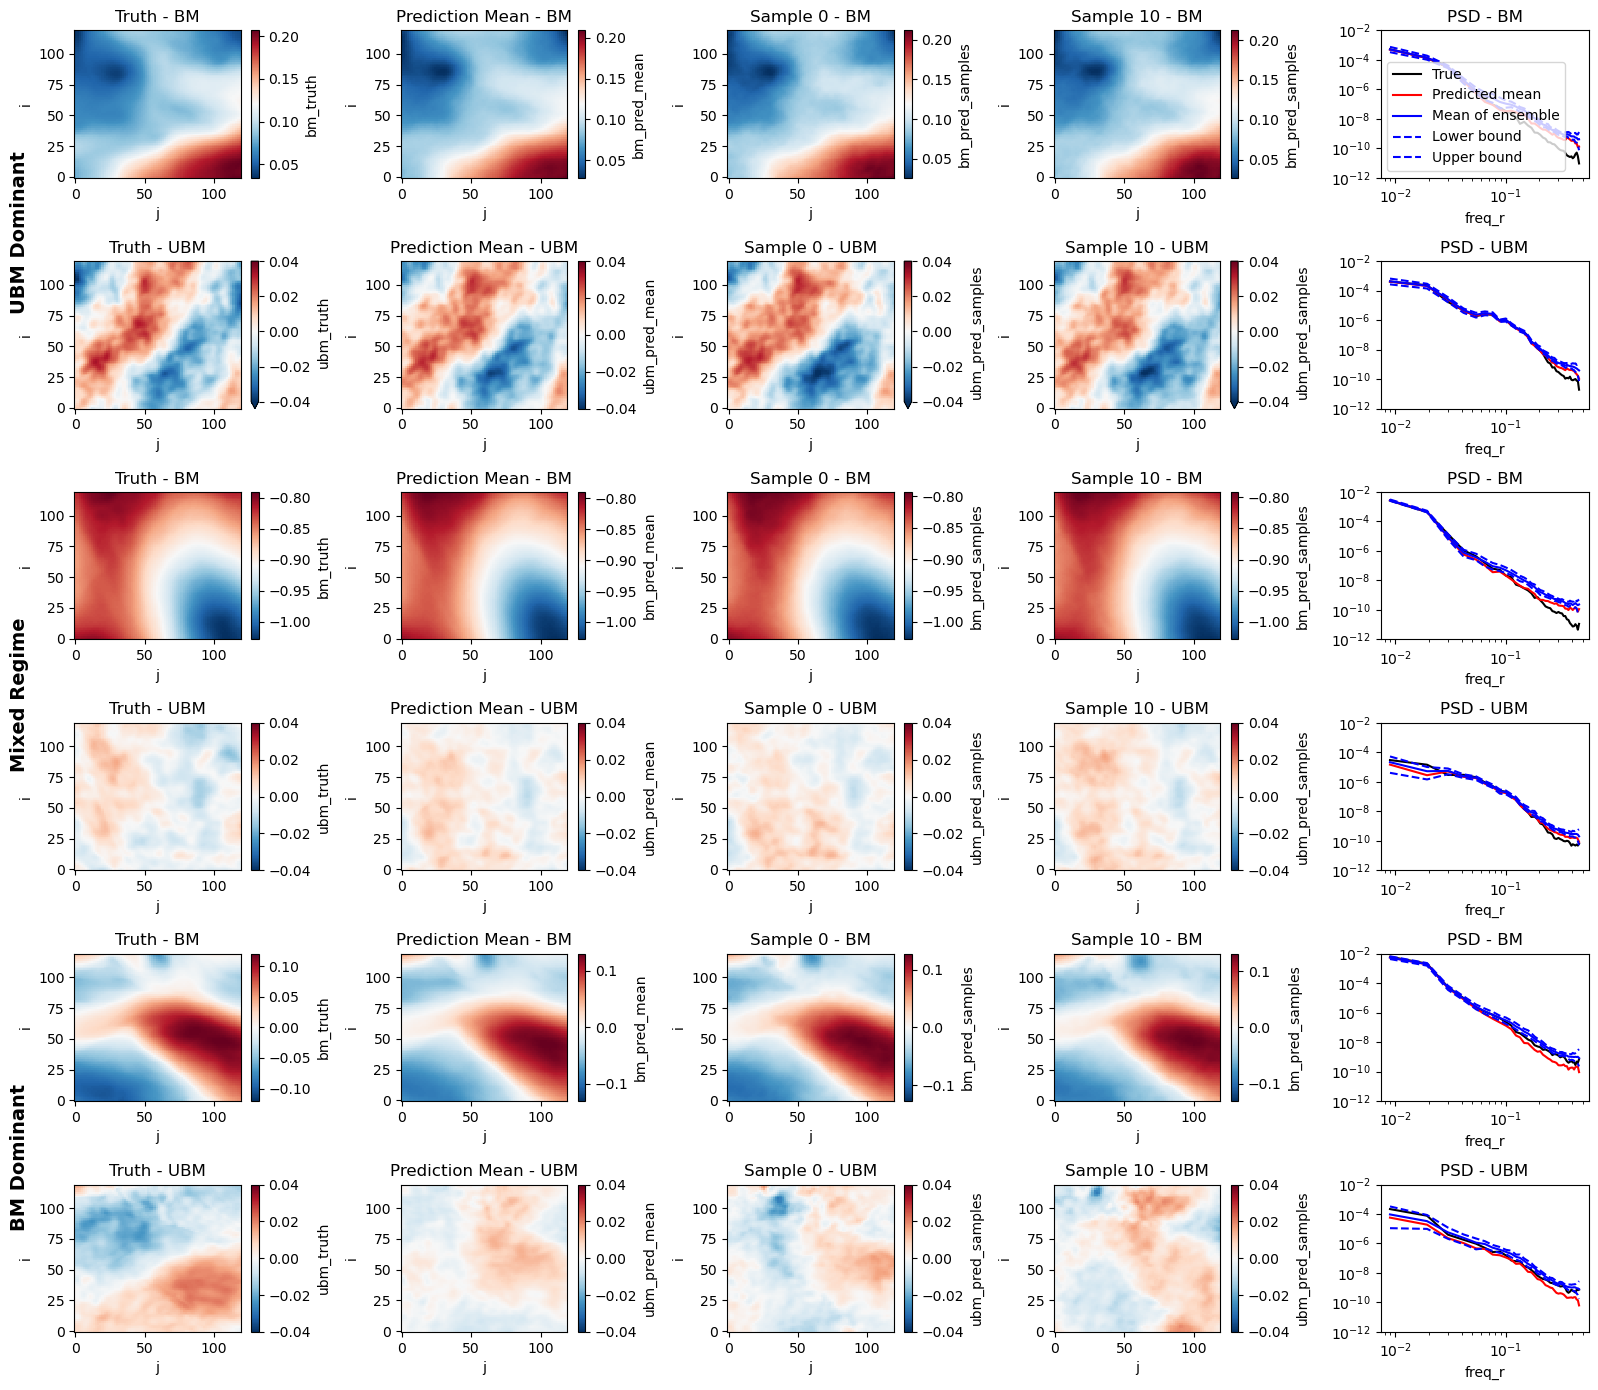

In [78]:
# Configuration for each bin with both BM and UBM settings
plot_configs = [
    ('bin_0', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_0', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_1', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_1', 'UBM', -0.04, 'ubm', {'vmin': -0.04}),
    ('bin_2', 'BM', -0.2, 'bm', {'cmap': 'RdBu_r'}),
    ('bin_2', 'UBM', -0.04, 'ubm', {'vmin': -0.04})
]

# Regime names for left-side labels
regime_names = ['UBM Dominant', 'Mixed Regime', 'BM Dominant']

# Plot specifications: (title, data_accessor_template)
plot_specs = [
    ('Truth', lambda nsamp, data_type: getattr(ds, f'{data_type}_truth').sel(sample=nsamp)),
    ('Prediction Mean', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp)),
    ('Sample 0', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=0)),
    ('Sample 10', lambda nsamp, data_type: getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp, stochastic_sample=10))
]

# Create the combined plot (now 6x5 to include PSD column)
plt.figure(figsize=(16, 14))

for row, (bin_key, model_type, vmin, data_type, plot_kwargs) in enumerate(plot_configs):
    nsamp = bins[bin_key][5]
    
    # Plot the 4 regular panels
    for col, (title, data_func) in enumerate(plot_specs):
        plt.subplot(6, 5, row * 5 + col + 1)
        data_func(nsamp, data_type).plot(**plot_kwargs)
        plt.title(f'{title} - {model_type}')
    
    # Add PSD panel as 5th column
    plt.subplot(6, 5, row * 5 + 5)
    
    # Calculate PSDs
    psd_true = isotropic_spectra(getattr(ds, f'{data_type}_truth').sel(sample=nsamp))
    psd_pred_mean = isotropic_spectra(getattr(ds, f'{data_type}_pred_mean').sel(sample=nsamp))
    psd_pred_samp = isotropic_spectra(getattr(ds, f'{data_type}_pred_samples').sel(sample=nsamp))
    
    # Plot PSDs
    psd_true.plot(color='k', label='True')
    psd_pred_mean.plot(color='r', label='Predicted mean')
    psd_pred_samp.mean('stochastic_sample').plot(color='b', label='Mean of ensemble')
    psd_pred_samp.quantile(0, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Lower bound')
    psd_pred_samp.quantile(1, 'stochastic_sample').plot(color='b', linestyle='dashed', label='Upper bound')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'PSD - {model_type}')
    plt.ylim([1e-12, 1e-2])
    
    # Add legend only for the first row to avoid clutter
    if row == 0:
        plt.legend()

# Add regime labels on the left side
for i, regime_name in enumerate(regime_names):
    # Position text at the middle of each pair of rows
    y_pos = 0.83 - (i * 0.33)  # Roughly centered between each pair of rows
    plt.figtext(0.01, y_pos, regime_name, rotation=90, fontsize=14, 
                weight='bold', ha='center', va='center')

plt.tight_layout()

plt.savefig('figures/ensemble_fig1.png', 
            bbox_inches='tight', dpi=300, facecolor='white', 
            edgecolor='none', format='png')